In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/benjaminrike1/social_score_csr_reports.git

Cloning into 'social_score_csr_reports'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 259 (delta 14), reused 43 (delta 13), pack-reused 215
Receiving objects: 100% (259/259), 786.58 MiB | 8.19 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Checking out files: 100% (79/79), done.


In [4]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 11.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [60]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm

In [68]:
data_path = ''
social_scores = pd.read_csv(data_path+'social_scores.csv', index_col=0)

In [69]:
# reading in company-ticker mapping
df_financial = pd.read_csv(data_path+'Tickers.csv', sep=';')
df_financial = df_financial[(df_financial['Ticker'])!='0'].reset_index(drop=True)
df_financial.head()

,Company,Ticker
0,ABNAMRO,ABN.AS
1,Amazon,AMZN
2,asr,ASRNL.AS
3,bam,BAMNB.AS
4,CocaCola,KO


In [71]:
# merging financial and social_scores df
df_financial = df_financial.merge(social_scores, on='Company')

In [56]:
# downloading company info from Yahoo
information = df_financial['Ticker'].apply(lambda x: yf.Ticker(x).info)
information

KeyboardInterrupt: 

In [73]:
# extracting sector, exchange and currency as features
df_financial['sector'] = [x.get('sector') for x in information]
df_financial['exchange'] = [x.get('exchange') for x in information]
df_financial['currency'] = [x.get('currency') for x in information]
df_financial['employees'] = [x.get('fullTimeEmployees') for x in information]
df_financial['country'] = [x.get('country') for x in information]
df_financial['ebitdaMargins'] = [x.get('ebitdaMargins') for x in information]
df_financial['revenueGrowth'] = [x.get('revenueGrowth') for x in information]
df_financial['ebitda'] = [x.get('ebitda') for x in information]
df_financial['totalRevenue'] = [x.get('totalRevenue') for x in information]
df_financial['enterpriseValue'] = [x.get('enterpriseValue') for x in information]
df_financial['marketCap'] = [x.get('marketCap') for x in information]


In [74]:
# extracting adujsted price for two dates
df_financial['adjusted_10.05.2020'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2020-05-11',progress=False)['Adj Close'].values[0])
df_financial['adjusted_10.05.2022'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2022-05-11',progress=False)['Adj Close'].values[0])

In [75]:
# adding exchange ticker to extract exchange prices
Ticker_exchange = {'NYQ': '^NYA', 'AMS': '^AEX', 'NMS': '^IXIC', 'LSE':'^FTSE' ,
 'STO':'^OMX', 'PNK':'^AEX','EBS':'^SSMI', 'GER':'^GDAXI', 'CPH':'^OMXC20'}
df_financial['Exchange_ticker'] = df_financial['exchange'].map(Ticker_exchange)
df_financial['Exchange_2020.05.10'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2020-05-10',progress=False).Close.values[0])
df_financial['Exchange_2022.05.10'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2022-05-10',progress=False).Close.values[0])

In [76]:
#Using dictionary to map currency to the Yahoo searchword for exchange rate

Valuta = {'EUR': 'EURUSD=x', 'DKK': 'DKKUSD=x', 'SEK': 'SEKUSD=x', 'CHF':'CHFUSD=x' ,
 'GBp':'GBPUSD=x', 'USD': 'USD=x'}
df_financial['valuta_ticker'] = df_financial['currency'].map(Valuta)

# Correcting for exchange rates for stock and stock exchange prices
df_financial['Exchange_rate_2020'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2020-05-10', progress=False).Close[0])
df_financial['Exchange_rate_2022'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2022-05-10', progress=False).Close[0])
df_financial['USD_adjusted_2020.10.05'] = df_financial['Exchange_rate_2020']*df_financial['adjusted_10.05.2020']
df_financial['USD_adjusted_2022.10.05'] = df_financial['Exchange_rate_2022']*df_financial['adjusted_10.05.2022']
df_financial['USD_Exchange_2020.10.05'] = df_financial['Exchange_rate_2020']*df_financial['Exchange_2020.05.10']
df_financial['USD_Exchange_2022.10.05'] = df_financial['Exchange_rate_2022']*df_financial['Exchange_2022.05.10']
df_financial.head()

,Company,Ticker,scores,sector,exchange,currency,employees,country,ebitdaMargins,revenueGrowth,...,Exchange_ticker,Exchange_2020.05.10,Exchange_2022.05.10,valuta_ticker,Exchange_rate_2020,Exchange_rate_2022,USD_adjusted_2020.10.05,USD_adjusted_2022.10.05,USD_Exchange_2020.10.05,USD_Exchange_2022.10.05
0,ABNAMRO,ABN.AS,0.253972,Financial Services,AMS,EUR,19957,Netherlands,0.00000,-0.027,...,^AEX,520.330017,669.739990,EURUSD=x,1.083952,1.053219,6.481927,11.695999,564.012799,705.383016
1,Amazon,AMZN,0.322418,Consumer Cyclical,NMS,USD,1622000,United States,0.11658,0.073,...,^IXIC,9192.339844,11623.250000,USD=x,1.000000,1.000000,2409.000000,2177.179932,9192.339844,11623.250000
2,asr,ASRNL.AS,0.280407,Financial Services,AMS,EUR,4155,Netherlands,0.15340,0.082,...,^AEX,520.330017,669.739990,EURUSD=x,1.083952,1.053219,21.545617,45.130441,564.012799,705.383016
3,bam,BAMNB.AS,0.381486,Industrials,AMS,EUR,15739,Netherlands,0.01844,0.000,...,^AEX,520.330017,669.739990,EURUSD=x,1.083952,1.053219,1.602081,2.529832,564.012799,705.383016
4,CocaCola,KO,0.317769,Consumer Defensive,NYQ,USD,79000,United States,0.33215,0.163,...,^NYA,11281.370117,15057.870117,USD=x,1.000000,1.000000,42.734627,64.010002,11281.370117,15057.870117


In [77]:
df_financial['return'] = (df_financial['USD_adjusted_2022.10.05']-df_financial['USD_adjusted_2020.10.05'])/(df_financial['USD_adjusted_2020.10.05'])
df_financial['exchange_return'] = (df_financial['USD_Exchange_2022.10.05']-df_financial['USD_Exchange_2020.10.05'])/(df_financial['USD_Exchange_2020.10.05'])

In [78]:
df_financial['constant'] = [1 for i in range(df_financial.shape[0])]
df_financial.head()

,Company,Ticker,scores,sector,exchange,currency,employees,country,ebitdaMargins,revenueGrowth,...,valuta_ticker,Exchange_rate_2020,Exchange_rate_2022,USD_adjusted_2020.10.05,USD_adjusted_2022.10.05,USD_Exchange_2020.10.05,USD_Exchange_2022.10.05,return,exchange_return,constant
0,ABNAMRO,ABN.AS,0.253972,Financial Services,AMS,EUR,19957,Netherlands,0.00000,-0.027,...,EURUSD=x,1.083952,1.053219,6.481927,11.695999,564.012799,705.383016,0.804402,0.250651,1
1,Amazon,AMZN,0.322418,Consumer Cyclical,NMS,USD,1622000,United States,0.11658,0.073,...,USD=x,1.000000,1.000000,2409.000000,2177.179932,9192.339844,11623.250000,-0.096231,0.264450,1
2,asr,ASRNL.AS,0.280407,Financial Services,AMS,EUR,4155,Netherlands,0.15340,0.082,...,EURUSD=x,1.083952,1.053219,21.545617,45.130441,564.012799,705.383016,1.094646,0.250651,1
3,bam,BAMNB.AS,0.381486,Industrials,AMS,EUR,15739,Netherlands,0.01844,0.000,...,EURUSD=x,1.083952,1.053219,1.602081,2.529832,564.012799,705.383016,0.579091,0.250651,1
4,CocaCola,KO,0.317769,Consumer Defensive,NYQ,USD,79000,United States,0.33215,0.163,...,USD=x,1.000000,1.000000,42.734627,64.010002,11281.370117,15057.870117,0.497849,0.334755,1


In [79]:
df_fin = pd.get_dummies(df_financial, columns=['sector'])

In [80]:
# list of features that should be used
features = ['scores', 'exchange_return', 'constant',
            'sector_Communication Services', 'sector_Consumer Cyclical',
            'sector_Consumer Defensive', 'sector_Financial Services',
            'sector_Healthcare', 'sector_Industrials'
            ]

label = 'return' # label that should be predicted

data = (df_fin[features].to_numpy(), df_fin[label].to_numpy())
res = sm.OLS(data[1], data[0]).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1.295
Date:                Sat, 21 May 2022   Prob (F-statistic):              0.313
Time:                        10:00:48   Log-Likelihood:                -25.457
No. Observations:                  25   AIC:                             68.91
Df Residuals:                      16   BIC:                             79.88
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.7950      3.303     -1.149      0.2

In [81]:
df_financial.columns

Index(['Company', 'Ticker', 'scores', 'sector', 'exchange', 'currency',
       'employees', 'country', 'ebitdaMargins', 'revenueGrowth', 'ebitda',
       'totalRevenue', 'enterpriseValue', 'marketCap', 'adjusted_10.05.2020',
       'adjusted_10.05.2022', 'Exchange_ticker', 'Exchange_2020.05.10',
       'Exchange_2022.05.10', 'valuta_ticker', 'Exchange_rate_2020',
       'Exchange_rate_2022', 'USD_adjusted_2020.10.05',
       'USD_adjusted_2022.10.05', 'USD_Exchange_2020.10.05',
       'USD_Exchange_2022.10.05', 'return', 'exchange_return', 'constant'],
      dtype='object')

In [83]:
corr_feat = ['return', 'scores','employees','ebitdaMargins','revenueGrowth','ebitda','totalRevenue','enterpriseValue','marketCap']
df_corr = df_financial[corr_feat]

In [84]:
# correlation plot
corr = df_corr.corr()
corr

,return,scores,employees,ebitdaMargins,revenueGrowth,ebitda,totalRevenue,enterpriseValue,marketCap
return,1.000000,-0.235212,-0.178905,-0.157180,0.536464,-0.116269,-0.167494,0.099904,0.044208
scores,-0.235212,1.000000,-0.015891,-0.380768,-0.113520,-0.505283,-0.220935,-0.543701,-0.551208
employees,-0.178905,-0.015891,1.000000,-0.016510,-0.000410,0.384513,0.854637,0.456293,0.451971
ebitdaMargins,-0.157180,-0.380768,-0.016510,1.000000,-0.181573,0.624645,0.274935,0.530732,0.550874
revenueGrowth,0.536464,-0.113520,-0.000410,-0.181573,1.000000,0.142301,0.100260,0.298886,0.257862
ebitda,-0.116269,-0.505283,0.384513,0.624645,0.142301,1.000000,0.767583,0.909847,0.942562
totalRevenue,-0.167494,-0.220935,0.854637,0.274935,0.100260,0.767583,1.000000,0.754649,0.770322
enterpriseValue,0.099904,-0.543701,0.456293,0.530732,0.298886,0.909847,0.754649,1.000000,0.994052
marketCap,0.044208,-0.551208,0.451971,0.550874,0.257862,0.942562,0.770322,0.994052,1.000000


<AxesSubplot:>

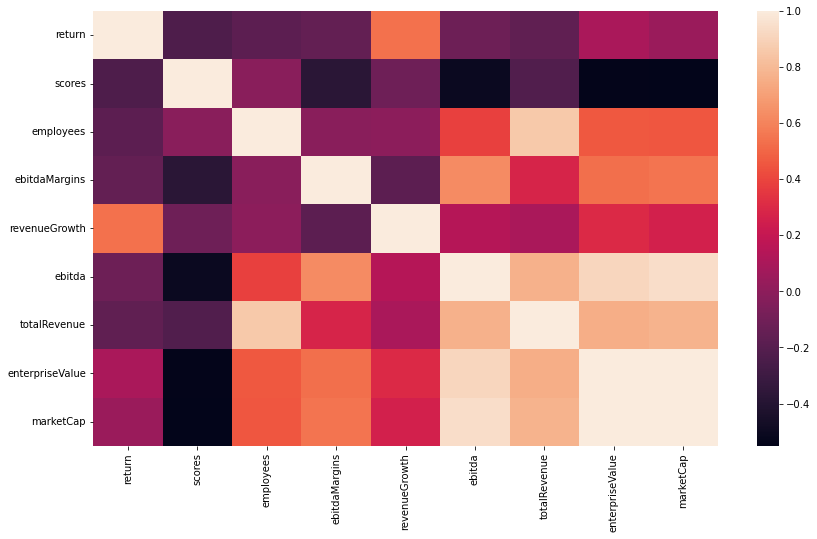

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(corr, ax=ax)